### Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Directory to Image
Dataset from Directory function in tensorflow allows us to directly create a dataset of images from as per the directory structure in which the images are stored.

In [2]:
# Intake images from the directory itself.
batch_size = 32
image_size = 256
channels = 3
epochs = 25
dataset = tf.keras.utils.image_dataset_from_directory(directory="Data\Skin cancer ISIC The International Skin Imaging Collaboration\Train",batch_size=batch_size,image_size=(image_size,image_size))
class_names=dataset.class_names

Found 2239 files belonging to 9 classes.


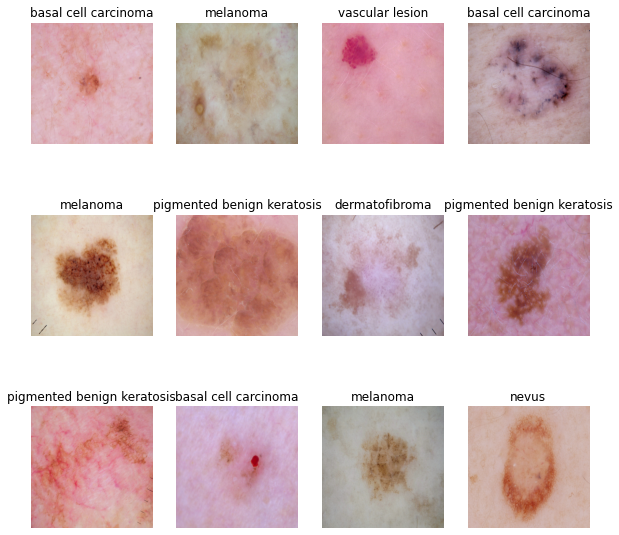

In [3]:
#Split the data
def  dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle_size:
        ds=ds.shuffle(shuffle_size,seed=42)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    validation_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds ,validation_ds ,test_ds

#Perform the split
train_ds , validation_ds ,test_ds=dataset_split(dataset)

#Plot random images from dataset
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [4]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
#Resize & Rescale & Data augmentation
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(image_size, image_size),
  tf.keras.layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [9]:
#Model
input_size = (batch_size,image_size,image_size,channels)

model = tf.keras.models.Sequential([
    data_augmentation,
    layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",input_shape=input_size),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(9,activation="softmax")
])

model.build(input_shape=input_size)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 32)         

In [10]:
from tensorflow.keras.optimizers import Adam

In [11]:
model.compile(optimizer= "Adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

history=model.fit(train_ds,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=val_ds)

Epoch 1/25
56/56 [==============================] - 68s 1s/step - loss: 5.5827 - accuracy: 0.2111 - val_loss: 1.9876 - val_accuracy: 0.2143
Epoch 2/25
56/56 [==============================] - 50s 888ms/step - loss: 1.8522 - accuracy: 0.3199 - val_loss: 1.6678 - val_accuracy: 0.4062
Epoch 3/25
56/56 [==============================] - 47s 847ms/step - loss: 1.6873 - accuracy: 0.4020 - val_loss: 1.6875 - val_accuracy: 0.3527
Epoch 4/25
13/56 [=====>........................] - ETA: 36s - loss: 1.6198 - accuracy: 0.4410

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_ds)

In [ ]:
#Matplotlib
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
loss=history.history['loss']

plt.figure(figsize=(8,4))
plt.plot(range(epochs),acc,label="Training Acc")
plt.plot(range(epochs),val_acc,label="Val Acc")
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')
#============================================#
plt.figure(figsize=(8,4))
plt.plot(range(epochs),loss,label="Training loss")
plt.plot(range(epochs),val_loss,label="Val loss")
plt.legend(loc="lower left")
plt.title('Training and Validation loss')

In [ ]:
for images_batch,label_batch in test_ds.take(1):
    
    first_image= images_batch[0].numpy().astype('uint8')
    first_label= label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("first image's actual label : ",class_names[first_label])
    
    batch_predict=model.predict(images_batch)
    print("first image's predicted label : ",class_names[np.argmax(batch_predict[0])])

In [ ]:
#function to predict 
def predict_name (model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    cofidence = round(100*(np.max(predictions[0])),2)
    return predicted_class , cofidence


In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):  
    for i in range(9):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        
        predicted_class,cofidence = predict_name(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted : {predicted_class},\n Cofidence {cofidence}")